## Import Libraries

In [39]:
import os
import torch
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
from torchvision import datasets, transforms, models
from collections import Counter
from torchvision.transforms import Resize, CenterCrop, ToTensor, Normalize, GaussianBlur, Grayscale
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Subset, Dataset

import cv2 
from PIL import Image, ImageFilter, ImageOps
from torchvision.transforms.functional import to_pil_image
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from torch.optim import lr_scheduler

from tkinter import filedialog, Tk

from gradcam import GradCAM, GradCAMpp
from gradcam.utils import visualize_cam

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

import dill
import torch.multiprocessing as mp

from captum.attr import IntegratedGradients
from captum.attr import visualization as viz

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # as M1 Mac Does not have a dedicated GPU

##### Specify the path to the locally saved dataset

In [32]:
train_data_dir = '/Users/savin/Desktop/FYP/Implementation/kaggle_dataset/AugmentedAlzheimerDataset'
original_dataset = datasets.ImageFolder(train_data_dir)

In [33]:
# class ContrastStretching:
#     def __call__(self, img):
#         img = np.array(img)
        
#         if img.ndim == 3:
#             img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

#         in_min = np.percentile(img, 0)
#         in_max = np.percentile(img, 100)

#         out_min, out_max = 0, 255
#         img = np.clip((img - in_min) * (out_max - out_min) / (in_max - in_min) + out_min, out_min, out_max)

#         return Image.fromarray(img.astype('uint8'))

class ContrastStretching:
    def __call__(self, img):
        # Convert PIL Image to NumPy array
        img_np = np.array(img)
        
        # Check if the image is grayscale or RGB
        if img_np.ndim == 2:  # Grayscale image
            img_np = self.apply_contrast_stretching(img_np)
        elif img_np.ndim == 3:  # RGB image
            # Apply contrast stretching to each channel individually
            for i in range(img_np.shape[-1]):
                img_np[:, :, i] = self.apply_contrast_stretching(img_np[:, :, i])
        
        # Convert back to PIL Image
        return Image.fromarray(img_np.astype('uint8'))
    
    def apply_contrast_stretching(self, channel):
        in_min, in_max = np.percentile(channel, (0, 100))
        out_min, out_max = 0, 255
        channel = np.clip((channel - in_min) * (out_max - out_min) / (in_max - in_min) + out_min, out_min, out_max)
        return channel

class UnsharpMask:
    def __init__(self, radius=1, percent=100, threshold=3):
        self.radius = radius
        self.percent = percent
        self.threshold = threshold

    def __call__(self, img):
        return img.filter(ImageFilter.UnsharpMask(radius=self.radius, 
                                                  percent=self.percent, 
                                                  threshold=self.threshold
                                                 ))

class GaussianBlur:
    def __init__(self, kernel_size, sigma=(0.1, 2.0)):
        self.kernel_size = kernel_size
        self.sigma = sigma

    def __call__(self, img):
        sigma = np.random.uniform(self.sigma[0], self.sigma[1])
        img = img.filter(ImageFilter.GaussianBlur(sigma))
        return img
    
    
    
# class CLAHE:
#     def __call__(self, img):
#         img = np.array(img)
#         img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#         clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
#         img = clahe.apply(img)
#         img = Image.fromarray(img)
#         return img
    
# class EdgeDetection:
#     def __call__(self, img):
#         img = np.array(img)
#         # Convert to grayscale if it's a color image
#         if img.ndim == 3:
#             img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#         # Apply Canny Edge Detector
#         edges = cv2.Canny(img, 100, 200)
#         return Image.fromarray(edges)

#### Preprocess the dataset

In [34]:
preprocess_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    ContrastStretching(),
    UnsharpMask(radius=1, percent=100, threshold=3),  
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 0.5)), 
    transforms.ToTensor()
])

preprocessed_dataset = datasets.ImageFolder(root=train_data_dir, transform=preprocess_transform)

data_loader = DataLoader(preprocessed_dataset, batch_size=32, shuffle=True)

In [35]:
def calculate_psnr_ssim(original_dataset, preprocessed_dataset, num_samples=100, resize=(224, 224)):
    psnr_values = []
    ssim_values = []

    for i in range(num_samples):
        original_img = original_dataset[i][0] # original MRI
        preprocessed_img = preprocessed_dataset[i][0] # preprocessed MRI

        if not isinstance(original_img, Image.Image):
            original_img = to_pil_image(original_img)
        if not isinstance(preprocessed_img, Image.Image):
            preprocessed_img = to_pil_image(preprocessed_img)

        # Convert MRI to grayscale
        original_img = original_img.convert("L")
        preprocessed_img = preprocessed_img.convert("L")

        # Resize images
        original_img = original_img.resize(resize)
        preprocessed_img = preprocessed_img.resize(resize)

        # Convert images to numpy arrays
        original_img_np = np.array(original_img)
        preprocessed_img_np = np.array(preprocessed_img)

        # Calculate PSNR and SSIM
        psnr = peak_signal_noise_ratio(original_img_np, preprocessed_img_np, data_range=original_img_np.max() - original_img_np.min())
        ssim = structural_similarity(original_img_np, preprocessed_img_np)

        psnr_values.append(psnr)
        ssim_values.append(ssim)

    # Compute average PSNR and SSIM
    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)

    return avg_psnr, avg_ssim

# Example usage
avg_psnr, avg_ssim = calculate_psnr_ssim(original_dataset, preprocessed_dataset)
print(f"Average PSNR: {avg_psnr}, Average SSIM: {avg_ssim}")

Average PSNR: 27.424622806629483, Average SSIM: 0.9004132035124346


preprocess_transform = transforms.Compose(

    transforms.Resize((224, 224)),  
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
    transforms.Lambda(lambda x: x.filter(ImageFilter.UnsharpMask(radius=2, percent=150, threshold=3))),
    transforms.ToTensor()
)

Average PSNR: 9.729432125669954, Average SSIM: 0.2833625979364462
____________________________________________________________________

preprocess_transform = transforms.Compose(

    transforms.Resize((224, 224)),
    transforms.ToTensor()
)

Average PSNR: 10.2026194786185, Average SSIM: 0.32374658927511385
____________________________________________________________________

preprocess_transform = transforms.Compose(

    transforms.Resize((224, 224)),
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)), 
    transforms.ToTensor(),
)

Average PSNR: 34.479706650199184, Average SSIM: 0.9638484917028203

____________________________________________________________________

preprocess_transform = transforms.Compose(

    transforms.Resize((224, 224)),
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 1.0)), 
    transforms.ToTensor(),
)

Average PSNR: 40.03000513450271, Average SSIM: 0.9923509776637894

____________________________________________________________________
preprocess_transform = transforms.Compose(

    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: img.filter(ImageFilter.UnsharpMask(radius=2, percent=100, threshold=3))),
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 0.5)), 
    transforms.ToTensor()
)

Average PSNR: 28.919164968402907, Average SSIM: 0.9646276430637585

____________________________________________________________________
preprocess_transform = transforms.Compose(

    transforms.Resize((224, 224)),
    ContrastStretching(),
    transforms.Lambda(lambda img: img.filter(ImageFilter.UnsharpMask(radius=1, percent=100, threshold=3))),
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 0.5)), 
    transforms.ToTensor()
)

Average PSNR: 27.194490517269728, Average SSIM: 0.8948121010151182

#### MRI scan counts in each class of the dataset

In [36]:
MildDemented = '/Users/savin/Desktop/FYP/Implementation/kaggle_dataset/AugmentedAlzheimerDataset/MildDemented'
ModerateDemented = '/Users/savin/Desktop/FYP/Implementation/kaggle_dataset/AugmentedAlzheimerDataset/ModerateDemented'
NonDemented = '/Users/savin/Desktop/FYP/Implementation/kaggle_dataset/AugmentedAlzheimerDataset/NonDemented'
VeryMildDemented = '/Users/savin/Desktop/FYP/Implementation/kaggle_dataset/AugmentedAlzheimerDataset/VeryMildDemented'

count_MildDemented = len(os.listdir(MildDemented))
count_ModerateDemented = len(os.listdir(ModerateDemented))
count_NonDemented = len(os.listdir(NonDemented))
count_VeryMildDemented = len(os.listdir(VeryMildDemented))

print(f"Number of images in MildDemented: {count_MildDemented}")
print(f"Number of images in ModerateDemented: {count_ModerateDemented}")
print(f"Number of images in NonDemented: {count_NonDemented}")
print(f"Number of images in VeryMildDemented: {count_VeryMildDemented}")

print(f"\nTotal MRIs in the dataset = {count_MildDemented+count_ModerateDemented+count_NonDemented+count_VeryMildDemented}" )

Number of images in MildDemented: 8960
Number of images in ModerateDemented: 6464
Number of images in NonDemented: 9600
Number of images in VeryMildDemented: 8960

Total MRIs in the dataset = 33984


#### Sample MRI before and after preprocessing

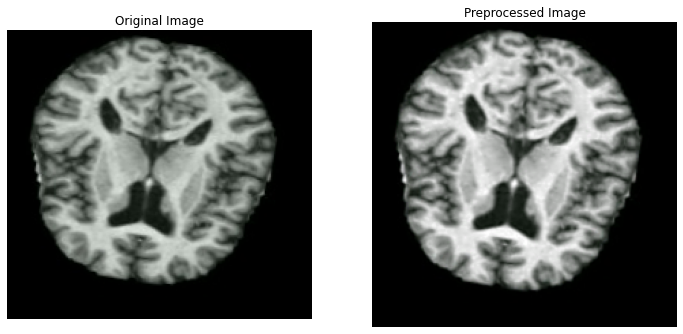

In [37]:
sample_image_path = os.path.join(MildDemented, os.listdir(MildDemented)[0])

original_image = Image.open(sample_image_path)

# Apply the preprocessing transforms
preprocessed_image = preprocess_transform(original_image)

preprocessed_image = transforms.ToPILImage()(preprocessed_image)

# Display the images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(preprocessed_image)
plt.title("Preprocessed Image")
plt.axis('off')

plt.show()

### Dataset splitting & creating DataLoaders

In [38]:
train_size = int(0.70 * len(preprocessed_dataset))
val_size = int(0.15 * len(preprocessed_dataset))
test_size = len(preprocessed_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(preprocessed_dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

In [40]:
all_labels = [label for _, label in train_dataset]
class_distribution = Counter(all_labels)
print(class_distribution)

Counter({2: 6737, 0: 6238, 3: 6236, 1: 4577})


## Building CNN

In [242]:
# class CNN(nn.Module):
#     def __init__(self, num_classes=4):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
#         self.conv2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
#         self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
#         self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
#         self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

#         self.pool = nn.MaxPool2d(kernel_size=3, stride=2)

#         self.fc1 = nn.Linear(256 * 6 * 6, 4096)
#         self.fc2 = nn.Linear(4096, 1024)  
#         self.output = nn.Linear(1024, num_classes)  

#         self.dropout = nn.Dropout(0.5)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = F.relu(self.conv3(x))
#         x = F.relu(self.conv4(x))
#         x = self.pool(F.relu(self.conv5(x)))

#         x = x.view(x.size(0), -1)  

#         x = self.dropout(F.relu(self.fc1(x)))
#         x = self.dropout(F.relu(self.fc2(x)))
        
#         x = self.output(x)

#         return x
    
#     def freeze_conv_layers(self):
#         for layer in [self.conv1, self.conv2, self.conv3, self.conv4, self.conv5]:
#             for param in layer.parameters():
#                 param.requires_grad = False
    
# cnn = CNN(num_classes=4)
# cnn.freeze_conv_layers()

# # If using pretrained AlexNet, load weights into first three conv layers
# for cnn_layer, alexnet_layer in zip(cnn_features, alexnet_features):
#     if isinstance(alexnet_layer, nn.Conv2d):
#         cnn_layer.weight.data = alexnet_layer.weight.data
#         cnn_layer.bias.data = alexnet_layer.bias.data

# # Forward pass for a sample input
# sample_input = torch.randn(1, 3, 224, 224)
# cnn.eval()
# sample_output = cnn(sample_input)

# print(cnn)
# summary(cnn, (3, 224, 224))

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (conv2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=1024, bias=True)
  (output): Linear(in_features=1024, out_features=4, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
         MaxPool2d-2           [-1, 64, 27, 27]               0
            Conv2d-3   

In [29]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)
    
class CNN2(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.se1 = SEBlock(64) 
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 384, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(384)
        self.se6 = SEBlock(384)

        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)

        self.fc1 = nn.Linear(384 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.output = nn.Linear(1024, num_classes)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)), negative_slope=0.01))
        x = self.se1(x)
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.01))
        x = F.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.01)
        x = F.leaky_relu(self.bn4(self.conv4(x)), negative_slope=0.01)
        x = self.pool(F.leaky_relu(self.bn5(self.conv5(x)), negative_slope=0.01))
        x = F.leaky_relu(self.bn6(self.conv6(x)), negative_slope=0.01)
        x = self.se6(x)

        x = x.view(x.size(0), -1)

        x = self.dropout(F.leaky_relu(self.fc1(x), negative_slope=0.01))
        x = self.dropout(F.leaky_relu(self.fc2(x), negative_slope=0.01))
        
        x = self.output(x)

        return x

cnn2 = CNN2(num_classes=4)
print(cnn2)
summary(cnn2, (3,224,224))

CNN2(
  (conv1): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (se1): SEBlock(
    (avg_pool): AdaptiveAvgPool2d(output_size=1)
    (fc): Sequential(
      (0): Linear(in_features=64, out_features=4, bias=False)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=4, out_features=64, bias=False)
      (3): Sigmoid()
    )
  )
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 256, kernel_size=(3, 3),

In [89]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=32):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn(self.conv(x)))
        out += residual
        return F.relu(out)

class CustomEfficientNet(nn.Module):
    def __init__(self, num_classes=4):
        super(CustomEfficientNet, self).__init__()
        self.base_model = models.efficientnet_b0(pretrained=True)
        
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        # Assuming the original EfficientNet-B0 model ends with global average pooling
        # and then a linear classifier, we insert the SEBlock and ResidualBlock
        # right before the global average pooling layer.
        
        # Replace the classifier with a new one
        num_ftrs = self.base_model.classifier[1].in_features
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

        # Add SEBlock and ResidualBlock to the end of the features, before the avgpool
        self.base_model.features.add_module("SEBlock", SEBlock(1280))  # Adjust in_channels accordingly
#         self.base_model.features.add_module("ResidualBlock", ResidualBlock(1280))  # Adjust in_channels accordingly

    def forward(self, x):
        # Process through EfficientNet up to before avgpool
        x = self.base_model.features(x)
        
        # Now x is a 4D tensor, and we can apply SEBlock and ResidualBlock directly
        # No need for separate calls, as they are part of the features module
        
        # Apply avgpool and classifier
        x = self.base_model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Creating the model and moving to device
model2 = CustomEfficientNet(num_classes=4).to(device)

# For a summary, ensure the input size matches your dataset
summary(model2, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

## Train Customized EfficientNet-B0

In [ ]:
criterion = nn.CrossEntropyLoss()
trainable_params = filter(lambda p: p.requires_grad, model2.parameters())
optimizer = torch.optim.Adam(trainable_params, lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
torch.autograd.set_detect_anomaly(True)

def train_epoch(epoch_index, train_loader, model, optimizer):
    model.train()  
    running_loss = 0.0
    correct_pred = 0
    total_pred = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch_index + 1} [train] Progress", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predictions = torch.max(outputs, 1)
        correct_pred += (predictions == labels).sum().item()
        total_pred += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    avg_acc = correct_pred / total_pred
    print(f'train Loss: {avg_loss:.4f} Acc: {avg_acc:.4f}')
    return avg_loss, avg_acc

def validate_epoch(epoch_index, val_loader, model):
    model.eval() 
    running_loss = 0.0
    correct_pred = 0
    total_pred = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch_index + 1} [val] Progress", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predictions = torch.max(outputs, 1)
            correct_pred += (predictions == labels).sum().item()
            total_pred += labels.size(0)

    avg_loss = running_loss / len(val_loader)
    avg_acc = correct_pred / total_pred
    print(f'val Loss: {avg_loss:.4f} Acc: {avg_acc:.4f}')
    return avg_loss, avg_acc

# Training loop
num_epochs = 50
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
best_val_loss = float('inf')
patience = 5

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(epoch, train_loader, model2, optimizer)
    val_loss, val_acc = validate_epoch(epoch, val_loader, model2)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(model2.state_dict(), 'model2.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over epochs')

plt.show()

Epoch 1 [train] Progress: 100%|████████████| 744/744 [21:46<00:00,  1.76s/batch]


train Loss: 1.1749 Acc: 0.4637


Epoch 1 [val] Progress: 100%|██████████████| 160/160 [03:45<00:00,  1.41s/batch]


val Loss: 1.0197 Acc: 0.5484


Epoch 2 [train] Progress: 100%|████████████| 744/744 [20:26<00:00,  1.65s/batch]


train Loss: 1.0291 Acc: 0.5413


Epoch 2 [val] Progress: 100%|██████████████| 160/160 [04:06<00:00,  1.54s/batch]


val Loss: 0.9474 Acc: 0.5711


Epoch 3 [train] Progress: 100%|████████████| 744/744 [20:36<00:00,  1.66s/batch]


train Loss: 0.9919 Acc: 0.5575


Epoch 3 [val] Progress: 100%|██████████████| 160/160 [03:58<00:00,  1.49s/batch]


val Loss: 0.9241 Acc: 0.5831


Epoch 4 [train] Progress: 100%|████████████| 744/744 [19:22<00:00,  1.56s/batch]


train Loss: 0.9617 Acc: 0.5698


Epoch 4 [val] Progress: 100%|██████████████| 160/160 [03:49<00:00,  1.44s/batch]


val Loss: 0.9065 Acc: 0.5878


Epoch 5 [train] Progress: 100%|████████████| 744/744 [19:22<00:00,  1.56s/batch]


train Loss: 0.9411 Acc: 0.5772


Epoch 5 [val] Progress: 100%|██████████████| 160/160 [03:52<00:00,  1.45s/batch]


val Loss: 0.8903 Acc: 0.5974


Epoch 6 [train] Progress: 100%|████████████| 744/744 [19:29<00:00,  1.57s/batch]


train Loss: 0.9248 Acc: 0.5859


Epoch 6 [val] Progress: 100%|██████████████| 160/160 [03:49<00:00,  1.44s/batch]


val Loss: 0.8699 Acc: 0.6108


Epoch 7 [train] Progress:  51%|██████▏     | 380/744 [10:10<11:00,  1.81s/batch]

In [43]:
# classification report (val loader)
def evaluate_model(model, dataloader):
    model.eval() 
    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    return true_labels, predictions

# Evaluate the model
true_labels, predictions = evaluate_model(model, val_loader)

# Print classification report
print(classification_report(true_labels, predictions, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

                  precision    recall  f1-score   support

    MildDemented       1.00      0.00      0.00      1371
ModerateDemented       0.19      1.00      0.31       948
     NonDemented       0.00      0.00      0.00      1436
VeryMildDemented       0.00      0.00      0.00      1342

        accuracy                           0.19      5097
       macro avg       0.30      0.25      0.08      5097
    weighted avg       0.30      0.19      0.06      5097



### Train the CNN model

In [244]:
# code to train and evaluate the Custom AlexNet model from scratch (without the pre-trained weights)

cnn = CNN(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

def train_epoch(epoch_index, train_loader, model, optimizer):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_pred = 0
    total_pred = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch_index + 1} [train] Progress", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predictions = torch.max(outputs, 1)
        correct_pred += (predictions == labels).sum().item()
        total_pred += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    avg_acc = correct_pred / total_pred
    print(f'train Loss: {avg_loss:.4f} Acc: {avg_acc:.4f}')
    return avg_loss, avg_acc

def validate_epoch(epoch_index, val_loader, model):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct_pred = 0
    total_pred = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch_index + 1} [val] Progress", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predictions = torch.max(outputs, 1)
            correct_pred += (predictions == labels).sum().item()
            total_pred += labels.size(0)

    avg_loss = running_loss / len(val_loader)
    avg_acc = correct_pred / total_pred
    print(f'val Loss: {avg_loss:.4f} Acc: {avg_acc:.4f}')
    return avg_loss, avg_acc

# Training loop
num_epochs = 25
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
best_val_loss = float('inf')
patience = 5

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(epoch, train_loader, cnn, optimizer)
    val_loss, val_acc = validate_epoch(epoch, val_loader, cnn)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(cnn.state_dict(), 'CNN_model.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over epochs')

plt.show()

Epoch 1 [train] Progress: 100%|████████████| 744/744 [19:46<00:00,  1.60s/batch]


train Loss: 1.3787 Acc: 0.2742


Epoch 1 [val] Progress: 100%|██████████████| 160/160 [01:13<00:00,  2.17batch/s]


val Loss: 1.3756 Acc: 0.2804


Epoch 2 [train] Progress: 100%|████████████| 744/744 [28:16<00:00,  2.28s/batch]


train Loss: 1.3770 Acc: 0.2772


Epoch 2 [val] Progress: 100%|██████████████| 160/160 [01:38<00:00,  1.63batch/s]


val Loss: 1.3756 Acc: 0.2804


Epoch 3 [train] Progress: 100%|████████████| 744/744 [30:53<00:00,  2.49s/batch]


train Loss: 1.3764 Acc: 0.2812


Epoch 3 [val] Progress: 100%|██████████████| 160/160 [01:56<00:00,  1.37batch/s]


val Loss: 1.3758 Acc: 0.2672


Epoch 4 [train] Progress: 100%|████████████| 744/744 [26:21<00:00,  2.13s/batch]


train Loss: 1.3768 Acc: 0.2780


Epoch 4 [val] Progress: 100%|██████████████| 160/160 [01:32<00:00,  1.74batch/s]


val Loss: 1.3761 Acc: 0.2804


Epoch 5 [train] Progress: 100%|████████████| 744/744 [25:18<00:00,  2.04s/batch]


train Loss: 1.3762 Acc: 0.2823


Epoch 5 [val] Progress: 100%|██████████████| 160/160 [01:26<00:00,  1.84batch/s]


val Loss: 1.3755 Acc: 0.2804


Epoch 6 [train] Progress:  10%|█▎           | 78/744 [02:22<20:16,  1.83s/batch]


KeyboardInterrupt: 

Epoch 1 [train] Progress: 100%|████████████| 744/744 [21:15<00:00,  1.71s/batch]


train Loss: 1.3237 Acc: 0.3816


Epoch 1 [val] Progress: 100%|██████████████| 160/160 [01:07<00:00,  2.38batch/s]


val Loss: 1.6542 Acc: 0.2733


Epoch 2 [train] Progress: 100%|████████████| 744/744 [23:48<00:00,  1.92s/batch]


train Loss: 1.0275 Acc: 0.5185


Epoch 2 [val] Progress: 100%|██████████████| 160/160 [01:14<00:00,  2.15batch/s]


val Loss: 0.9786 Acc: 0.5458


Epoch 3 [train] Progress: 100%|████████████| 744/744 [22:56<00:00,  1.85s/batch]


train Loss: 0.8535 Acc: 0.5903


Epoch 3 [val] Progress: 100%|██████████████| 160/160 [01:09<00:00,  2.32batch/s]


val Loss: 0.8713 Acc: 0.5548


Epoch 4 [train] Progress: 100%|████████████| 744/744 [22:30<00:00,  1.81s/batch]


train Loss: 0.7914 Acc: 0.6234


Epoch 4 [val] Progress: 100%|██████████████| 160/160 [01:10<00:00,  2.25batch/s]


val Loss: 0.9906 Acc: 0.5360


Epoch 5 [train] Progress: 100%|████████████| 744/744 [25:41<00:00,  2.07s/batch]


train Loss: 0.7477 Acc: 0.6436


Epoch 5 [val] Progress: 100%|██████████████| 160/160 [02:02<00:00,  1.30batch/s]


val Loss: 0.8744 Acc: 0.5386


Epoch 6 [train] Progress: 100%|████████████| 744/744 [29:59<00:00,  2.42s/batch]


train Loss: 0.7006 Acc: 0.6719


Epoch 6 [val] Progress: 100%|██████████████| 160/160 [01:33<00:00,  1.71batch/s]


val Loss: 1.0309 Acc: 0.4930


Epoch 7 [train] Progress: 100%|████████████| 744/744 [30:29<00:00,  2.46s/batch]


train Loss: 0.6696 Acc: 0.6910


Epoch 7 [val] Progress: 100%|██████████████| 160/160 [01:39<00:00,  1.61batch/s]


val Loss: 1.3398 Acc: 0.4815


Epoch 8 [train] Progress: 100%|████████████| 744/744 [30:44<00:00,  2.48s/batch]


train Loss: 0.6261 Acc: 0.7121


Epoch 8 [val] Progress: 100%|██████████████| 160/160 [01:33<00:00,  1.71batch/s]


val Loss: 0.6014 Acc: 0.7326


Epoch 9 [train] Progress: 100%|████████████| 744/744 [27:28<00:00,  2.22s/batch]


train Loss: 0.5959 Acc: 0.7293


Epoch 9 [val] Progress: 100%|██████████████| 160/160 [01:30<00:00,  1.77batch/s]


val Loss: 0.9389 Acc: 0.6620


Epoch 10 [train] Progress: 100%|███████████| 744/744 [27:21<00:00,  2.21s/batch]


train Loss: 0.5518 Acc: 0.7505


Epoch 10 [val] Progress: 100%|█████████████| 160/160 [01:28<00:00,  1.81batch/s]


val Loss: 0.4871 Acc: 0.7726


Epoch 11 [train] Progress: 100%|███████████| 744/744 [26:24<00:00,  2.13s/batch]


train Loss: 0.5218 Acc: 0.7577


Epoch 11 [val] Progress: 100%|█████████████| 160/160 [01:22<00:00,  1.94batch/s]


val Loss: 0.4733 Acc: 0.7777


Epoch 12 [train] Progress: 100%|███████████| 744/744 [26:38<00:00,  2.15s/batch]


train Loss: 0.4946 Acc: 0.7765


Epoch 12 [val] Progress: 100%|█████████████| 160/160 [01:25<00:00,  1.87batch/s]


val Loss: 0.6057 Acc: 0.6937


Epoch 13 [train] Progress: 100%|███████████| 744/744 [27:27<00:00,  2.21s/batch]


train Loss: 0.4705 Acc: 0.7880


Epoch 13 [val] Progress: 100%|█████████████| 160/160 [01:28<00:00,  1.80batch/s]


val Loss: 0.4687 Acc: 0.7742


Epoch 14 [train] Progress: 100%|███████████| 744/744 [26:45<00:00,  2.16s/batch]


train Loss: 0.4379 Acc: 0.8028


Epoch 14 [val] Progress: 100%|█████████████| 160/160 [01:26<00:00,  1.84batch/s]


val Loss: 0.4712 Acc: 0.7932


Epoch 15 [train] Progress: 100%|███████████| 744/744 [26:14<00:00,  2.12s/batch]


train Loss: 0.4182 Acc: 0.8155


Epoch 15 [val] Progress: 100%|█████████████| 160/160 [01:21<00:00,  1.96batch/s]


val Loss: 0.3934 Acc: 0.8413


Epoch 16 [train] Progress: 100%|███████████| 744/744 [26:32<00:00,  2.14s/batch]


train Loss: 0.3904 Acc: 0.8286


Epoch 16 [val] Progress: 100%|█████████████| 160/160 [01:25<00:00,  1.88batch/s]


val Loss: 0.3664 Acc: 0.8466


Epoch 17 [train] Progress: 100%|███████████| 744/744 [25:33<00:00,  2.06s/batch]


train Loss: 0.3673 Acc: 0.8415


Epoch 17 [val] Progress: 100%|█████████████| 160/160 [01:19<00:00,  2.02batch/s]


val Loss: 0.4622 Acc: 0.8170


Epoch 18 [train] Progress: 100%|███████████| 744/744 [25:58<00:00,  2.10s/batch]


train Loss: 0.3430 Acc: 0.8559


Epoch 18 [val] Progress: 100%|█████████████| 160/160 [01:20<00:00,  1.99batch/s]


val Loss: 0.3063 Acc: 0.8687


Epoch 19 [train] Progress: 100%|███████████| 744/744 [26:59<00:00,  2.18s/batch]


train Loss: 0.3278 Acc: 0.8625


Epoch 19 [val] Progress: 100%|█████████████| 160/160 [01:25<00:00,  1.87batch/s]


val Loss: 0.3276 Acc: 0.8476


Epoch 20 [train] Progress: 100%|███████████| 744/744 [25:34<00:00,  2.06s/batch]


train Loss: 0.2920 Acc: 0.8806


Epoch 20 [val] Progress: 100%|█████████████| 160/160 [01:27<00:00,  1.83batch/s]


val Loss: 0.3053 Acc: 0.8705


Epoch 21 [train] Progress: 100%|███████████| 744/744 [24:47<00:00,  2.00s/batch]


train Loss: 0.2772 Acc: 0.8877


Epoch 21 [val] Progress: 100%|█████████████| 160/160 [01:21<00:00,  1.96batch/s]


val Loss: 0.2119 Acc: 0.9149


Epoch 22 [train] Progress: 100%|███████████| 744/744 [24:13<00:00,  1.95s/batch]


train Loss: 0.2597 Acc: 0.8954


Epoch 22 [val] Progress: 100%|█████████████| 160/160 [01:20<00:00,  1.99batch/s]


val Loss: 0.3000 Acc: 0.8958


Epoch 23 [train] Progress: 100%|███████████| 744/744 [22:59<00:00,  1.85s/batch]


train Loss: 0.2412 Acc: 0.9051


Epoch 23 [val] Progress: 100%|█████████████| 160/160 [01:14<00:00,  2.14batch/s]


val Loss: 0.2290 Acc: 0.9154


Epoch 24 [train] Progress: 100%|███████████| 744/744 [29:18<00:00,  2.36s/batch]


train Loss: 0.2233 Acc: 0.9131


Epoch 24 [val] Progress: 100%|█████████████| 160/160 [01:16<00:00,  2.09batch/s]


val Loss: 0.2386 Acc: 0.9160


Epoch 25 [train] Progress: 100%|███████████| 744/744 [24:00<00:00,  1.94s/batch]


train Loss: 0.2051 Acc: 0.9218


Epoch 25 [val] Progress: 100%|█████████████| 160/160 [01:15<00:00,  2.12batch/s]


val Loss: 0.5017 Acc: 0.8713


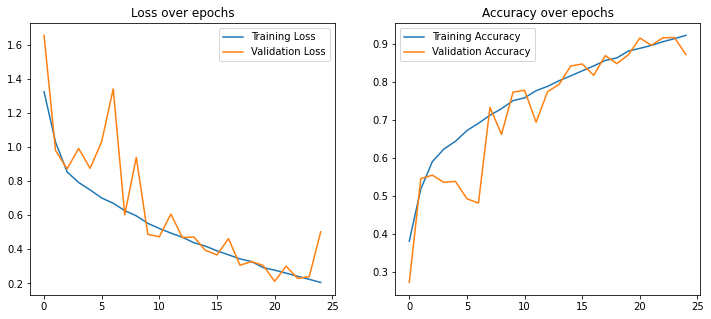

In [345]:
cnn2 = CNN2(num_classes=4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn2.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

def train_epoch(epoch_index, train_loader, model, optimizer):
    model.train()  
    running_loss = 0.0
    correct_pred = 0
    total_pred = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch_index + 1} [train] Progress", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predictions = torch.max(outputs, 1)
        correct_pred += (predictions == labels).sum().item()
        total_pred += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    avg_acc = correct_pred / total_pred
    print(f'train Loss: {avg_loss:.4f} Acc: {avg_acc:.4f}')
    return avg_loss, avg_acc

def validate_epoch(epoch_index, val_loader, model):
    model.eval() 
    running_loss = 0.0
    correct_pred = 0
    total_pred = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch_index + 1} [val] Progress", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predictions = torch.max(outputs, 1)
            correct_pred += (predictions == labels).sum().item()
            total_pred += labels.size(0)

    avg_loss = running_loss / len(val_loader)
    avg_acc = correct_pred / total_pred
    print(f'val Loss: {avg_loss:.4f} Acc: {avg_acc:.4f}')
    return avg_loss, avg_acc

# Training loop
num_epochs = 25
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
best_val_loss = float('inf')
patience = 5

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(epoch, train_loader, cnn2, optimizer)
    val_loss, val_acc = validate_epoch(epoch, val_loader, cnn2)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(cnn2.state_dict(), 'model1.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over epochs')

plt.show()

In [349]:
torch.save(cnn2.state_dict(), 'CNN2.pth') # saving the trained model

In [21]:
# classification report (val loader)
loaded_model = CNN2(num_classes=4).to(device)

loaded_model.load_state_dict(torch.load('CNN2.pth'))

def evaluate_model(model, dataloader):
    model.eval() 
    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    return true_labels, predictions

# Evaluate the model
true_labels, predictions = evaluate_model(loaded_model, val_loader)

# Print classification report
print(classification_report(true_labels, predictions, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

                  precision    recall  f1-score   support

    MildDemented       0.98      0.72      0.83      1367
ModerateDemented       0.80      1.00      0.89      1002
     NonDemented       0.83      0.91      0.87      1438
VeryMildDemented       0.79      0.78      0.79      1290

        accuracy                           0.84      5097
       macro avg       0.85      0.85      0.84      5097
    weighted avg       0.86      0.84      0.84      5097



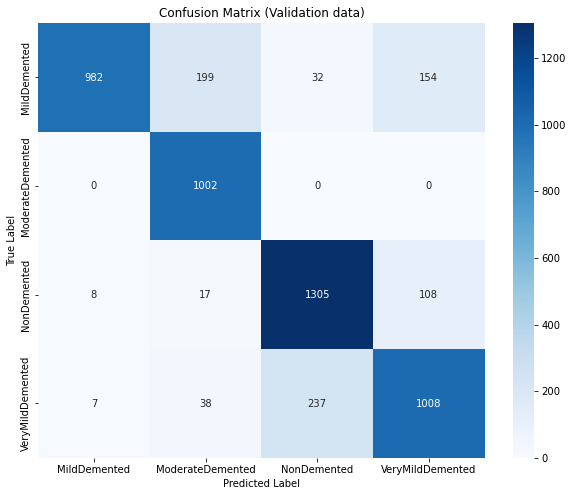

In [22]:
# Confusion Matrix on Val Loader

def get_predictions(model, dataloader):
    model.eval()  
    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    return true_labels, predictions

# Evaluate the model
true_labels, predictions = get_predictions(loaded_model, val_loader)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Validation data)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [27]:
def load_and_predict(image_path, model, transform, device, class_names):
    model.eval()
    image = Image.open(image_path)# Convert to grayscale
    image = transform(image)
    image = image.repeat(3, 1, 1)  # Repeat the single channel three times to create a 3-channel image
    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]

    return predicted_class

# Class names
class_names = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented']

Tk().withdraw()
image_path = filedialog.askopenfilename()

if image_path:
    predicted_class = load_and_predict(image_path, loaded_model, preprocess_transform, device, class_names)
    print(f'Predicted class: {predicted_class}')
    print(image_path)
else:
    print("No file was selected.")

2024-02-02 12:19:07.978 python[37026:2254141] +[CATransaction synchronize] called within transaction
2024-02-02 12:19:08.023 python[37026:2254141] +[CATransaction synchronize] called within transaction
2024-02-02 12:19:09.656 python[37026:2254141] +[CATransaction synchronize] called within transaction


Predicted class: Mild Demented
/Users/savin/Desktop/FYP/Implementation/kaggle_dataset/Test_Dataset/MildDemented/mildDem709.jpg


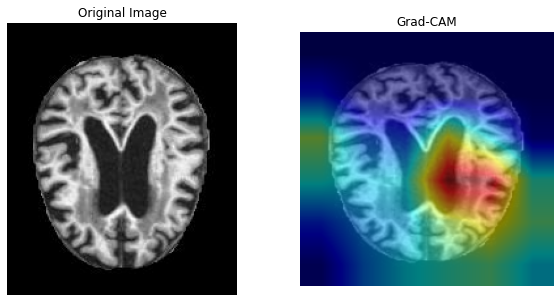

In [28]:
# Preprocessing function
def preprocess_image(image_path):
    # Open the image file
    image = Image.open(image_path)

    # Convert the image to RGB if it is not already
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Apply the preprocessing transforms
    image_tensor = preprocess_transform(image).unsqueeze(0).to(device)

    return image_tensor, image

# Grad-CAM function
def apply_gradcam(model, image_tensor, target_layer):
    gradcam = GradCAM(model, target_layer)
    mask, _ = gradcam(image_tensor)
    heatmap, result = visualize_cam(mask, image_tensor)

    return heatmap, result

# Load and preprocess image
input_image_path = image_path
image_tensor, original_image = preprocess_image(input_image_path)

# Apply Grad-CAM (adjust target layer as needed)
target_layer = loaded_model.conv6  # Example: last conv layer in features
heatmap, cam_result = apply_gradcam(loaded_model, image_tensor, target_layer)

# Visualization
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cam_result.permute(1, 2, 0).cpu().numpy())
plt.title('Grad-CAM')
plt.axis('off')

plt.show()